In [ ]:
!pip3 install opendatasets tqdm

In [5]:
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-flowers/main/dataset.py -O
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-flowers/main/model.py -O
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-flowers/main/diffusion.py -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2411  100  2411    0     0  43836      0 --:--:-- --:--:-- --:--:-- 46365
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  7286  100  7286    0     0  30418      0 --:--:-- --:--:-- --:--:-- 30742
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3680  100  3680    0     0  16214      0 --:--:-- --:--:-- --:--:-- 16355


In [1]:
from google.colab import drive

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from dataset import collate_maker
from diffusion import Diffusion, diffusion_test_beta
from model import UNet

from tqdm import tqdm

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

import os
import glob
import opendatasets as od

In [ ]:
drive.mount('/content/drive')

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
root_data_path = os.path.join('.', 'dataset')
if not os.path.exists(root_data_path):
  os.mkdir(root_data_path)

database_url = 'https://www.kaggle.com/datasets/yousefmohamed20/oxford-102-flower-dataset'
od.download(database_url, data_dir=root_data_path)

In [ ]:
def find_folder(path:str, folder:str) -> str:
  folders = []
  for file in glob.glob(os.path.join(path, '*')):
    if os.path.isdir(file):
      if file.lower().find(folder.lower()) != -1:
        return file
      else:
        folders.append(file)
  for file in folders:
    try:
      return find_folder(file, folder)
    except FileNotFoundError:
      pass

  raise FileNotFoundError(f'Folder \'{folder}\' not found!')

def find_images(path: str) -> list[str]:
  images = glob.glob(os.path.join(path, '*.jpg'))
  for path in glob.glob(os.path.join(path, '*/')):
    imgs = find_images(path)
    images.extend(imgs)
  return images

root_data_path = os.path.join('.', 'dataset')

test_path = find_folder(root_data_path, 'test')
train_path = find_folder(root_data_path, 'train')
valid_path = find_folder(root_data_path, 'valid')

test_images = find_images(test_path)
train_images = find_images(train_path)
valid_images = find_images(valid_path)

df = pd.DataFrame({ 'path': test_images })
df.to_csv('test_set.csv', index=None)

df = pd.DataFrame({ 'path': train_images })
df.to_csv('train_set.csv', index=None)

df = pd.DataFrame({ 'path': valid_images })
df.to_csv('valid_set.csv', index=None)

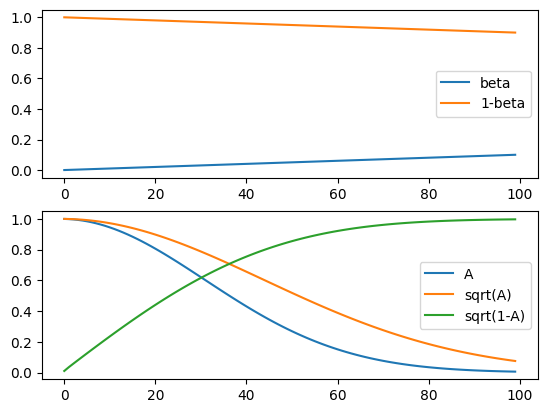

In [2]:
diffusion_test_beta(1e-4, 1e-1, 100)

In [100]:
def load_model(model:nn.Module, model_path:str) -> dict:
  if os.path.exists(os.path.join(model_path, 'history.json')):
    with open(os.path.join(model_path, 'history.json')) as f:
      history = json.loads(f.read())
    print('history file: Loaded...')
  else:
    history = {
      'loss': [],
      'better_loss': None,
      'last_loss': None,
    }
    print('history file: Generated...')

  if os.path.exists(os.path.join(model_path, 'last.pt')):
    print('Model: Loaded...')
    model.load_state_dict(torch.load(os.path.join(model_path, 'last.pt')))
  else:
    print('Model: Generated...')
  return history

def save_model(model:nn.Module, history:dict, model_path:str):
  if not os.path.exists(model_path):
    os.mkdir(model_path)
  
  loss_total = history['loss'][-1]

  if history['better_loss'] is None or history['better_loss'] > loss_total:
    history['better_loss'] = loss_total
    torch.save(model.state_dict(), os.path.join(model_path, 'better.pt'))

  history['last_loss'] = loss_total
  torch.save(model.state_dict(), os.path.join(model_path, 'last.pt'))

  with open(os.path.join(model_path, 'history.json'), 'w') as f:
    f.write(json.dumps(history))

def sample_random(index:int, diffusion:Diffusion, model:nn.Module, model_path:str):
  gen_path = os.path.join(model_path, 'gen_random')
  sample = diffusion.sample(model, 16).detach().cpu().moveaxis(1, -1)
  plt.figure(figsize=(4, 4))
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample[i])
    plt.axis('off')
  plt.subplots_adjust(wspace=0.04, hspace=0.04)

  if not os.path.exists(gen_path):
    os.mkdir(gen_path)

  plt.savefig(os.path.join(gen_path, os.path.extsep.join(['0'*(10-len(str(index))) + str(index), 'jpg'])))

def sample_from_source(index:int, diffusion:Diffusion, model:nn.Module, model_path:str, device):
  gen_path = os.path.join(model_path, 'gen_src')
  df_test = pd.read_csv('test_set.csv')
  collate_fn = collate_maker(64, 0.3)
  dl_test = DataLoader(df_test['path'].values, 6, False, collate_fn=collate_fn)

  src, tgt = next(iter(dl_test))

  sample = diffusion.sample(model, 6, src.to(device))

  src = src.detach().cpu().moveaxis(1, -1).numpy()
  tgt = tgt.detach().cpu().moveaxis(1, -1).numpy()
  sample = sample.detach().cpu().moveaxis(1, -1).numpy()

  plt.figure(figsize=(6, 3))
  for i in range(6):
    idx = i * 3
    plt.subplot(3, 6, idx+1)
    plt.imshow(tgt[i] * 0.5 + 0.5)
    plt.axis('off')
    plt.subplot(3, 6, idx+2)
    plt.imshow(src[i], cmap='gray')
    plt.axis('off')
    plt.subplot(3, 6, idx+3)
    plt.imshow(sample[i])
    plt.axis('off')
  plt.subplots_adjust(wspace=0.04, hspace=0.04)
  if not os.path.exists(gen_path):
    os.mkdir(gen_path)

  plt.savefig(os.path.join(gen_path, os.path.extsep.join(['0'*(10-len(str(index))) + str(index), 'jpg'])))

In [36]:
batch_size = 8
image_size = 64
diffusion_steps = 100
beta_start = 1e-4
beta_end = 1e-1

collate_fn = collate_maker(image_size, 0.3)
df = pd.read_csv('train_set.csv')
dl = DataLoader(df['path'].values, batch_size, True, collate_fn=collate_fn)
diffusion = Diffusion(diffusion_steps, beta_start, beta_end, image_size, device)

model = UNet(device=device).to(device)

#model_path = '/content/drive/MyDrive/ml/flowers'
model_path = os.path.join('.', 'model')

history = load_model(model, model_path)

history file: Loaded...
Model: Loaded...


In [16]:
epochs = 1
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

model.train()

for epoch in range(epochs):
  loss_total = 0.0

  pbar = tqdm(total=len(dl), desc=f'Train ({len(history['loss'])+epoch+1}/{epochs}))', position=0, colour='yellow')
  for src, tgt in dl:
    src = src.to(device)
    tgt = tgt.to(device)

    t = diffusion.sample_timesteps(tgt.shape[0])
    x_t, noise = diffusion.noise_image(tgt, t)
    predicted_noise = model(x_t, t, src if random.random() < 0.1 else None)

    loss = loss_fn(noise, predicted_noise)
    loss_total += loss.item() * tgt.shape[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix(MSE=loss.item())
    pbar.update(1)

    del src, tgt, t, x_t, noise

  loss_total /= len(dl.dataset)

  pbar.set_postfix(MSE=loss_total)
  pbar.close()

  # Save Model and results

  history['loss'].append(loss_total)
  save_model(model, history, model_path)
  
  sample_from_source(len(history['loss']), diffusion, model, model_path, device)
  sample_random(len(history['loss']), diffusion, model, model_path)

Train:   3%|▎         | 27/819 [07:12<3:36:25, 16.40s/it, MSE=0.0825]

KeyboardInterrupt: 